<a href="https://colab.research.google.com/github/BrodyVogel/ANLY-590-Deep-Learning/blob/master/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Aerial Image Classification

## Data Processing: Train Test Split

In [0]:
from google.colab import drive
! ls

gdrive	sample_data


In [0]:
# connect to Google drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!ls gdrive/'My Drive'/DeepLearningProj

UCMerced_LandUse


In [0]:
# move to data directory, data source: http://weegee.vision.ucmerced.edu/datasets/landuse.html
% cd gdrive/'My Drive'/DeepLearningProj/UCMerced_LandUse

/content/gdrive/My Drive/DeepLearningProj/UCMerced_LandUse


In [0]:
# import libraries
import os
import shutil
import random as rand

In [0]:
# list files
os.listdir()

#! rm -r Train
#! rm -r Test

['Images',
 '.DS_Store',
 'readme.txt',
 'readme.txt.bak',
 'TrainSet',
 'TestSet',
 'VGGTransferLearning2.h5',
 'CNNmod3.h5']

In [0]:
# look at number of labels and images for each
imgsource = "./Images"
labels = os.listdir(imgsource)
labels = labels[0:(len(labels)-1)]
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print(num_classes, ':', num_imgs)

21 : [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [0]:
# label names
print(labels)

['buildings', 'forest', 'river', 'golfcourse', 'mobilehomepark', 'harbor', 'runway', 'agricultural', 'chaparral', 'tenniscourt', 'intersection', 'overpass', 'baseballdiamond', 'parkinglot', 'airplane', 'sparseresidential', 'storagetanks', 'mediumresidential', 'freeway', 'beach', 'denseresidential']


In [0]:
# check if train/test split needs to be generated
trainpath = "./TrainSet"
testpath = "./TestSet"
split = input("Generate train/test split? (y/n)\t")
if split.lower()=='y':
  split_into_train_test = True
else:
  split_into_train_test = False

Generate train/test split? (y/n)	n


In [0]:
# ~ 15mins
# generate train/test split if 'y'
if split_into_train_test:
  # delete directories if they already exist
  if 'TrainSet' in os.listdir():
    ! rm -r TrainSet
  if 'TestSet' in os.listdir():
    ! rm -r TestSet
  # generate new folders
  os.makedirs(trainpath)
  os.makedirs(testpath)
  os.listdir()
  # for each label generate new folders
  for fold in labels:
    # randomly shuffle whether to copy image
    split = [True]*20+[False]*80
    rand.shuffle(split)
    img_files = os.listdir(imgsource+'/'+fold)
    os.makedirs(trainpath+'/'+fold)
    os.makedirs(testpath+'/'+fold)
    for f in img_files:
      if split.pop():
        shutil.copyfile(imgsource+'/'+fold+'/'+f, testpath+'/'+fold+'/'+f)
      else:
        shutil.copyfile(imgsource+'/'+fold+'/'+f, trainpath+'/'+fold+'/'+f)

In [0]:
# look at number of labels and images for each train/test set
imgsource = trainpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Training set\t', num_classes, 'classes :', num_imgs)

imgsource = testpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Test set\t', num_classes, 'classes :', num_imgs)

Training set	 21 classes : [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Test set	 21 classes : [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


## Image Classification

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


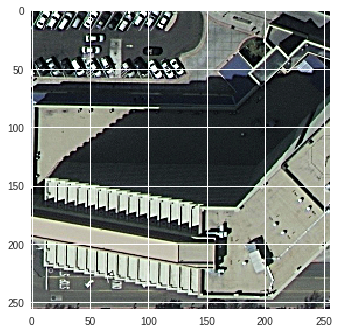

In [0]:
# display an image from training data
l = labels[0]
f = os.listdir('./TrainSet/'+l+'/')
plt.imshow(load_img('./TrainSet/'+l+'/'+f[0]))
plt.show()

### Image Generators

In [0]:
# build image generators for models
path_train_data = "./TrainSet/"
path_test_data = "./TestSet/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        class_mode='categorical')

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


### VGG16 Transfer Learning: Static

In [0]:
# build CNN with transfer learning using VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dense(21, activation="sigmoid"))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fix base weights
conv_base.trainable = False
model1.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(32768, 256) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 21) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(21,) dtype=float32_ref>]

In [0]:
# check new number of trainable parameters
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 8,394,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# compile model
model1.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [0]:
# load model weights
#model.load_weights('VGGTransferLearning.h5')
# or
# train model
# ~15 minutes to run
transfer_learning_mod = model1.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)
# save weights
model1.save_weights('VGGTransferLearning.h5')

Epoch 1/5
100/100 [==============================] - 236s 2s/step - loss: 0.9238 - acc: 0.7584 - val_loss: 0.4930 - val_acc: 0.8471
Epoch 2/5
100/100 [==============================] - 206s 2s/step - loss: 0.2240 - acc: 0.9448 - val_loss: 0.3734 - val_acc: 0.8741
Epoch 3/5
100/100 [==============================] - 213s 2s/step - loss: 0.0948 - acc: 0.9806 - val_loss: 0.2281 - val_acc: 0.9241
Epoch 4/5
100/100 [==============================] - 212s 2s/step - loss: 0.0526 - acc: 0.9900 - val_loss: 0.2681 - val_acc: 0.9207
Epoch 5/5
100/100 [==============================] - 211s 2s/step - loss: 0.0303 - acc: 0.9941 - val_loss: 0.4457 - val_acc: 0.8655


In [0]:
# function to plot performance
def plotModPerf(mod):
  acc = mod.history['acc']
  val_acc = mod.history['val_acc']
  loss = mod.history['loss']
  val_loss = mod.history['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = 'Training loss')
  plt.plot(epochs, val_loss, label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label = 'Training acc')
  plt.plot(epochs, val_acc, label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

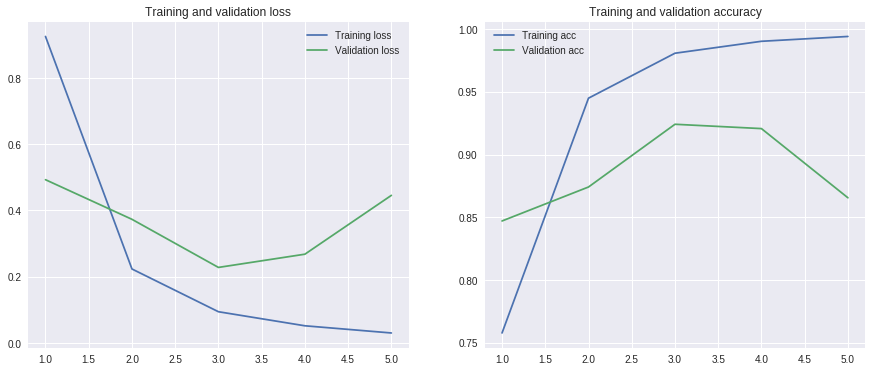

In [0]:
# function to plot performance
plotModPerf(transfer_learning_mod)

In [0]:
# look at labels of the test set
print(test_generator.class_indices)
class_labels = {}
# switch key and values for class labels
for k, v in test_generator.class_indices.items():
  class_labels[str(v)]=k
print(class_labels)

{'tenniscourt': 0, 'parkinglot': 1, 'mobilehomepark': 2, 'overpass': 3, 'sparseresidential': 4, 'river': 5, 'storagetanks': 6, 'runway': 7, 'freeway': 8, 'intersection': 9, 'chaparral': 10, 'harbor': 11, 'mediumresidential': 12, 'forest': 13, 'golfcourse': 14, 'buildings': 15, 'beach': 16, 'agricultural': 17, 'airplane': 18, 'baseballdiamond': 19, 'denseresidential': 20}
{'0': 'tenniscourt', '1': 'parkinglot', '2': 'mobilehomepark', '3': 'overpass', '4': 'sparseresidential', '5': 'river', '6': 'storagetanks', '7': 'runway', '8': 'freeway', '9': 'intersection', '10': 'chaparral', '11': 'harbor', '12': 'mediumresidential', '13': 'forest', '14': 'golfcourse', '15': 'buildings', '16': 'beach', '17': 'agricultural', '18': 'airplane', '19': 'baseballdiamond', '20': 'denseresidential'}


In [0]:
# build functions to look at misclassifications
def display(misclass):
  plt.figure(figsize=(15, 10))

  n = int(np.ceil(np.sqrt(len(misclass))))
  ind = 1
  for y, yhat, x in misclass:
    plt.subplot(n, n, ind)  
    plt.grid(False)
    plt.axis('off')
    plt.text(.5, .5, y+'->\n'+yhat, fontsize=9, color='red')
    plt.imshow(x)
    ind +=1
  plt.show()

def eval_model(model, img_gen):
  
  ind = 1
  
  misclass = []
  
  for i in range(len(img_gen)):
    xs, ys = img_gen.next()
    ys = [class_labels[str(np.argmax(l))]  for l in ys]
    yhats = model.predict(xs)
    yhats = [class_labels[str(np.argmax(p))] for p in yhats]
    
    for y, yhat, x in (list(zip(ys, yhats, xs))):
      if y != yhat:
        misclass.append((y, yhat, x))
  display(misclass)
  misclass = [y+'->'+yhat for y, yhat, x in misclass]
  [print(cnt) for cnt in Counter(misclass).most_common()]

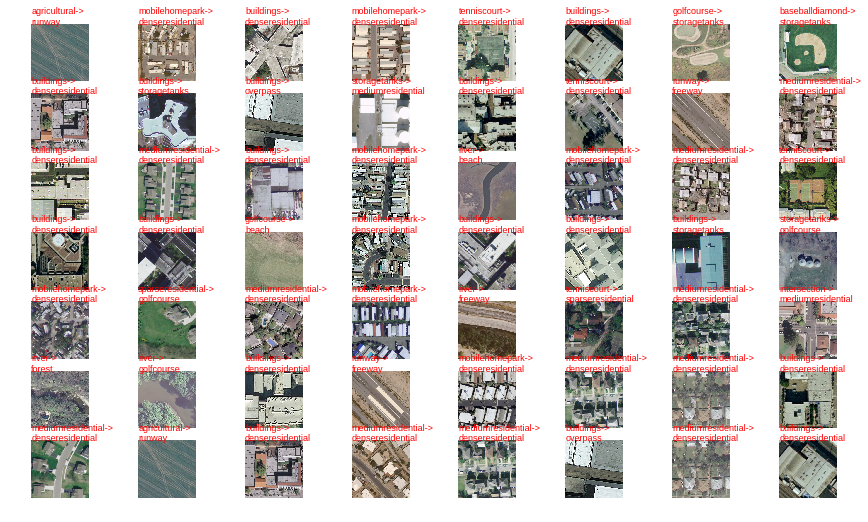

('buildings->denseresidential', 14)
('mediumresidential->denseresidential', 11)
('mobilehomepark->denseresidential', 8)
('tenniscourt->denseresidential', 3)
('agricultural->runway', 2)
('buildings->storagetanks', 2)
('buildings->overpass', 2)
('runway->freeway', 2)
('golfcourse->storagetanks', 1)
('baseballdiamond->storagetanks', 1)
('storagetanks->mediumresidential', 1)
('river->beach', 1)
('golfcourse->beach', 1)
('storagetanks->golfcourse', 1)
('sparseresidential->golfcourse', 1)
('river->freeway', 1)
('tenniscourt->sparseresidential', 1)
('intersection->mediumresidential', 1)
('river->forest', 1)
('river->golfcourse', 1)


In [0]:
# look at misclassifications
eval_model(model1, test_generator)

In [0]:
del model1

### VGG16 Transfer Learning: Non-Static

In [0]:
# build another CNN with transfer learning using VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dense(21, activation="sigmoid"))
model2.summary()

58892288/58889256 [==============================] - 13s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# have static base weights
conv_base.trainable = True
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
model2.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [0]:
# load model weights
# model2.load_weights('VGGTransferLearning2.h5')
# or
# train model
# ~30 minutes to run
transfer_learning_mod2 = model2.fit_generator(train_generator, steps_per_epoch=100, epochs=7, 
                                            validation_data=test_generator, validation_steps=25)
# save weights
model2.save_weights('VGGTransferLearning2.h5')

Epoch 1/7
100/100 [==============================] - 417s 4s/step - loss: 2.2857 - acc: 0.2885 - val_loss: 1.1322 - val_acc: 0.5371
Epoch 2/7
100/100 [==============================] - 392s 4s/step - loss: 0.8105 - acc: 0.7378 - val_loss: 0.8919 - val_acc: 0.7403
Epoch 3/7
100/100 [==============================] - 391s 4s/step - loss: 0.4103 - acc: 0.8775 - val_loss: 0.3574 - val_acc: 0.8957
Epoch 4/7
100/100 [==============================] - 391s 4s/step - loss: 0.3091 - acc: 0.9233 - val_loss: 0.8877 - val_acc: 0.7974
Epoch 5/7
100/100 [==============================] - 390s 4s/step - loss: 0.2255 - acc: 0.9417 - val_loss: 0.3180 - val_acc: 0.9060
Epoch 6/7
100/100 [==============================] - 390s 4s/step - loss: 0.1626 - acc: 0.9579 - val_loss: 0.3090 - val_acc: 0.9126
Epoch 7/7
100/100 [==============================] - 390s 4s/step - loss: 0.1415 - acc: 0.9680 - val_loss: 0.6296 - val_acc: 0.9121


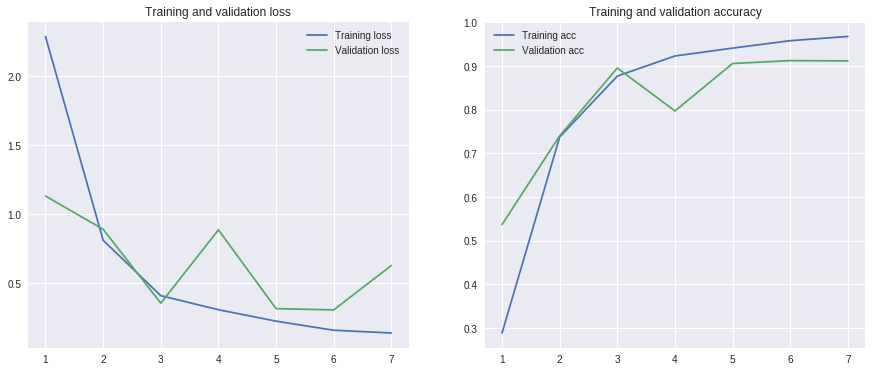

In [0]:
# plot performance
plotModPerf(transfer_learning_mod2)

In [0]:
del model2

### Fully Trained CNN

In [0]:
# build a CNN from scratch without transfer learning
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(256, 256, 3)))
model3.add(Conv2D(filters = 32, kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model3.add(MaxPooling2D(pool_size=(5,5)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(21, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               20480256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [0]:
# compile model
model3.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [0]:
# load model weights
 model3.load_weights('CNNmod3.h5')
# or
# ~2 hours to run
#training_mod = model3.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
#                                            validation_data=test_generator, validation_steps=25)
# save weights
#model3.save_weights('CNNmod3.h5')

In [0]:
# plot performance
plotModPerf(training_mod)

NameError: ignored

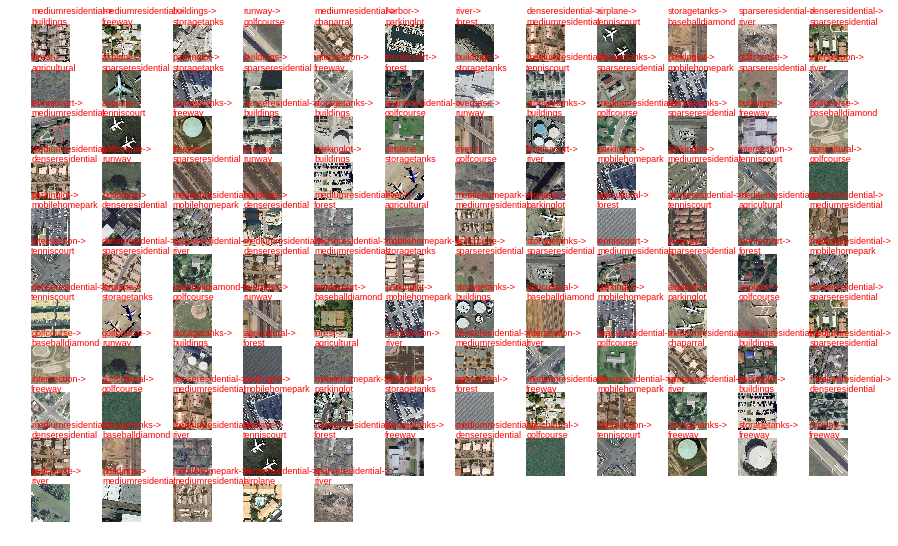

('parkinglot->mobilehomepark', 6)
('denseresidential->mediumresidential', 5)
('mediumresidential->denseresidential', 5)
('sparseresidential->river', 4)
('storagetanks->freeway', 4)
('storagetanks->buildings', 4)
('airplane->tenniscourt', 3)
('denseresidential->sparseresidential', 3)
('storagetanks->sparseresidential', 3)
('intersection->river', 3)
('intersection->tenniscourt', 3)
('agricultural->golfcourse', 3)
('agricultural->forest', 3)
('mediumresidential->buildings', 2)
('mediumresidential->freeway', 2)
('buildings->storagetanks', 2)
('mediumresidential->chaparral', 2)
('storagetanks->baseballdiamond', 2)
('forest->agricultural', 2)
('parkinglot->storagetanks', 2)
('intersection->freeway', 2)
('tenniscourt->forest', 2)
('golfcourse->sparseresidential', 2)
('tenniscourt->mediumresidential', 2)
('sparseresidential->golfcourse', 2)
('overpass->runway', 2)
('golfcourse->baseballdiamond', 2)
('golfcourse->runway', 2)
('freeway->sparseresidential', 2)
('parkinglot->buildings', 2)
('airpl

In [0]:
# look at misclassifications
eval_model(model3, test_generator)

In [0]:
from keras import models
# this is to understand what the layers are looking for
def get_activations(image, model):
  # understand what each layer outputs
  layer_outputs = [layer.output for layer in model.layers]
  # get the activation outputs for each of the layers and return them
  activations = models.Model(inputs=model.input, outputs=layer_outputs).predict(image)
  return activations

In [0]:
from PIL import Image

l = labels[0]
f = os.listdir('./TrainSet/'+l+'/')
img_path = './TrainSet/'+l+'/'+f[0]
img = Image.open(img_path).convert('RGB')
imagearray = np.asarray(img)

# here are those activations     "expand_dims" so the model gets the four dimensions it's expecting
activations = get_activations(np.expand_dims(imagearray[:, :, :], axis = 0) , model3)

In [0]:
# activations for the convolutional layers and the pooling layer
first_layer = activations[0]
second_layer = activations[1]
pooling_layer = activations[2]

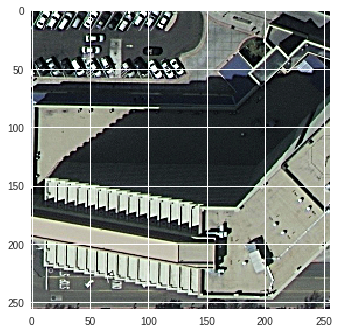

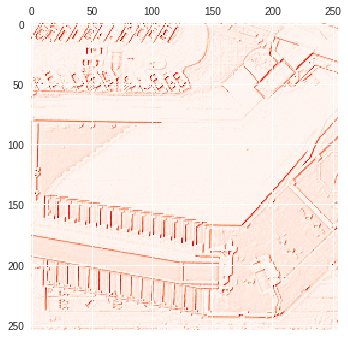

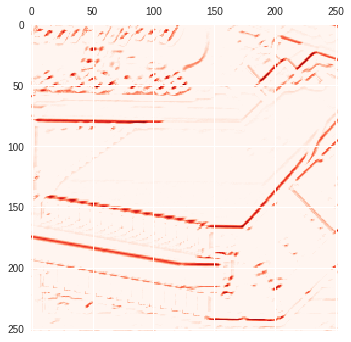

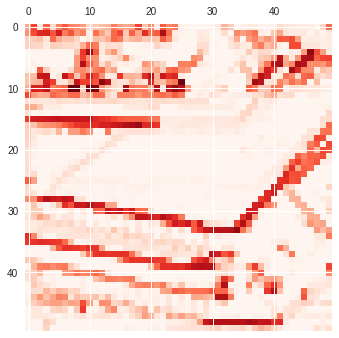

In [0]:
# plot the image and then an example of a kernel in each layer is looking for
plt.matshow(first_layer[0,:,:,0], cmap = 'Reds')
plt.matshow(second_layer[0,:,:,0], cmap = 'Reds')
plt.matshow(pooling_layer[0,:,:,0], cmap = 'Reds')

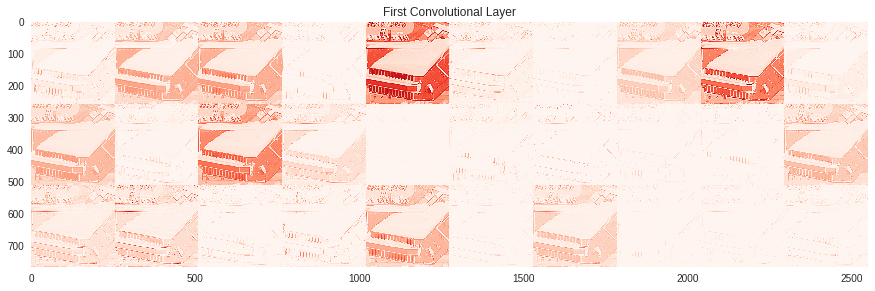

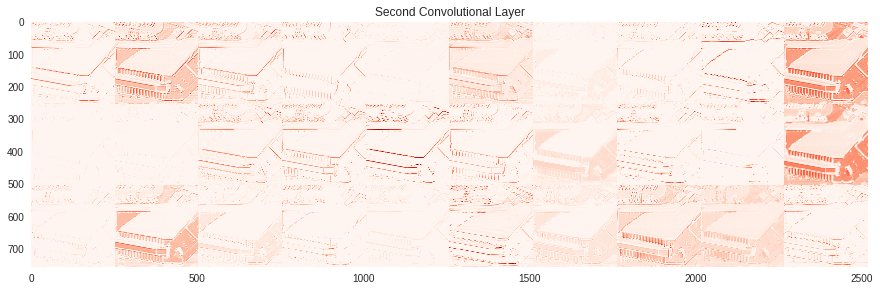

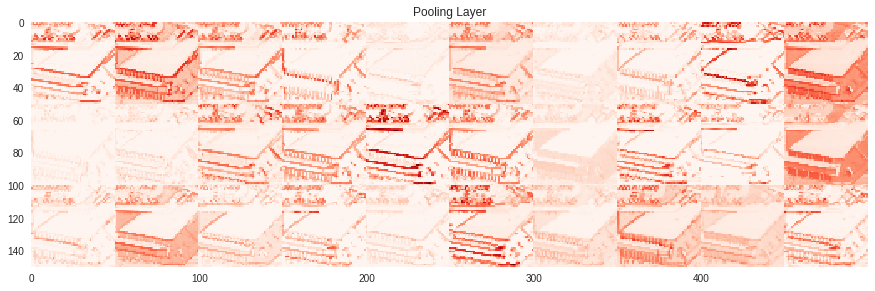

In [0]:
# look at the activation for every kernel
  # took most of this from Keegan's notebook
layer_names = ["First Convolutional Layer", "Second Convolutional Layer", "Pooling Layer"]
    
images_per_row = 10

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap = 'Reds')
    
# you can see that almost half the kernels go dead


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


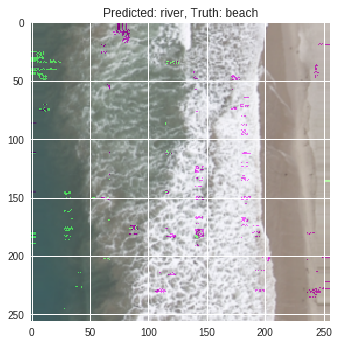

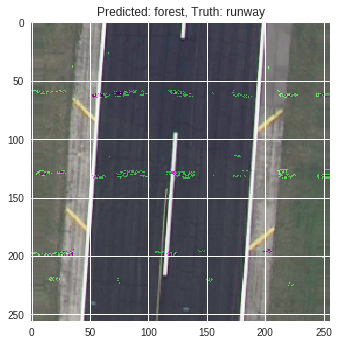

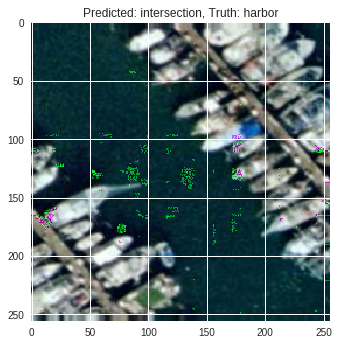

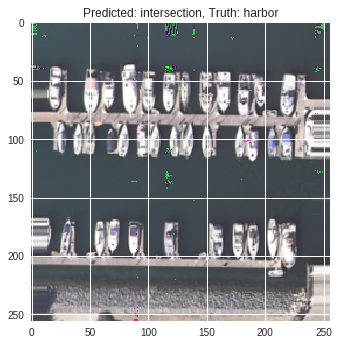

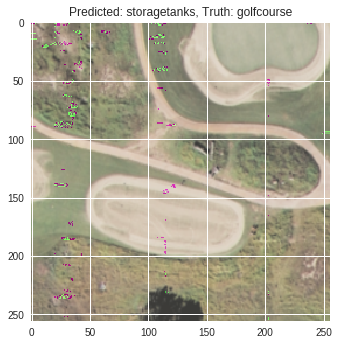

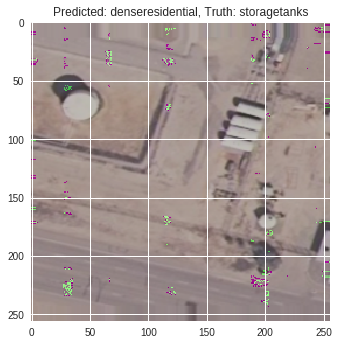

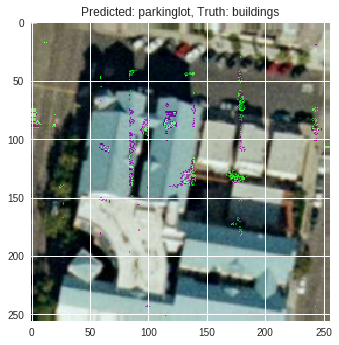

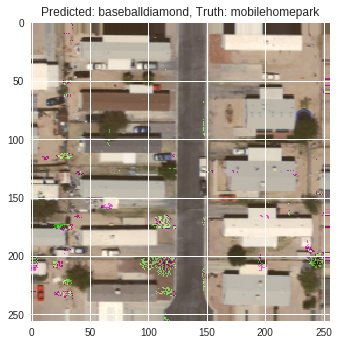

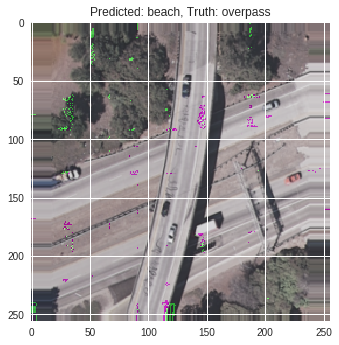

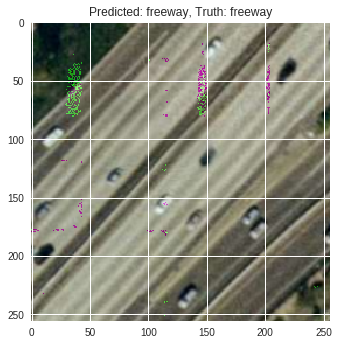

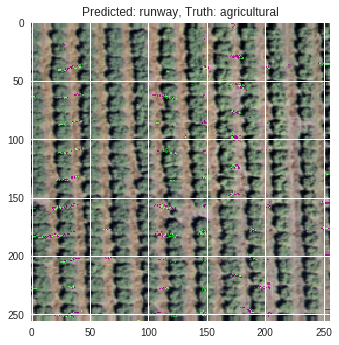

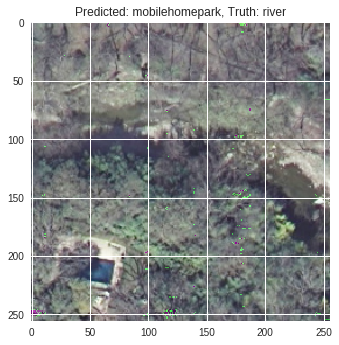

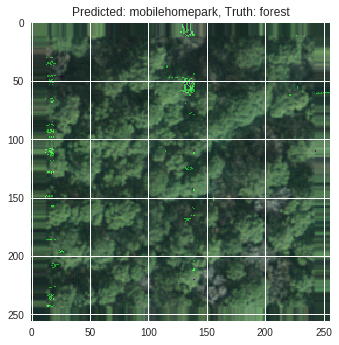

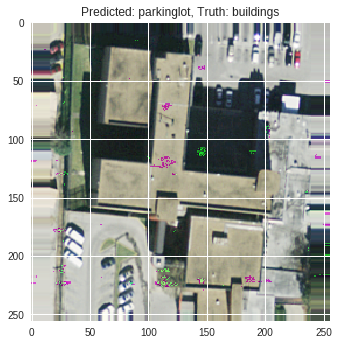

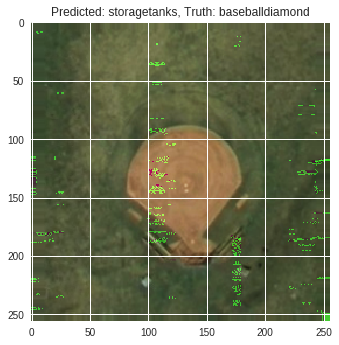

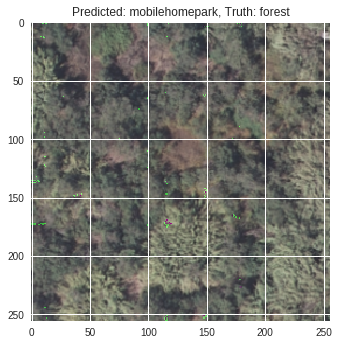

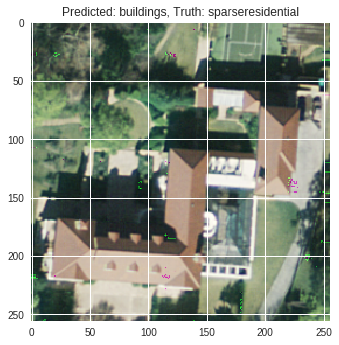

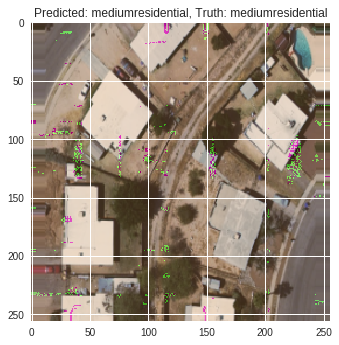

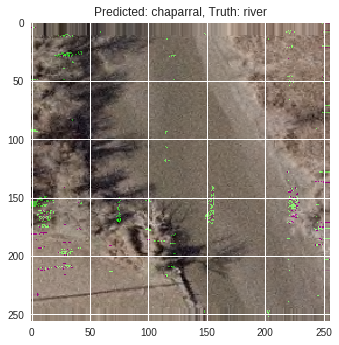

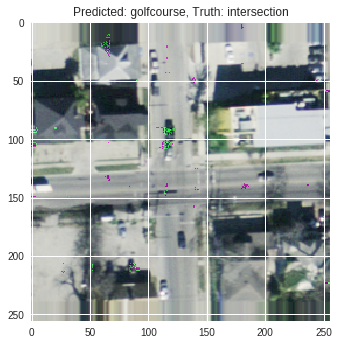

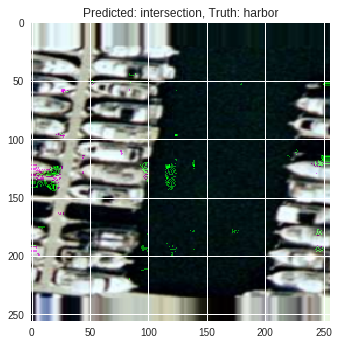

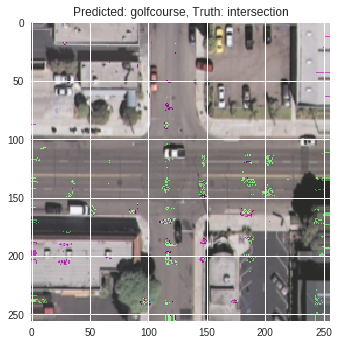

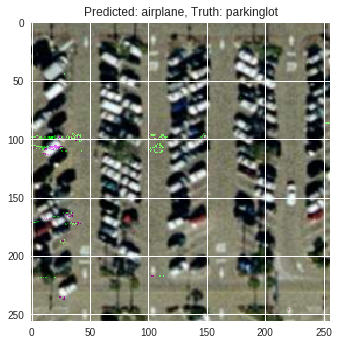

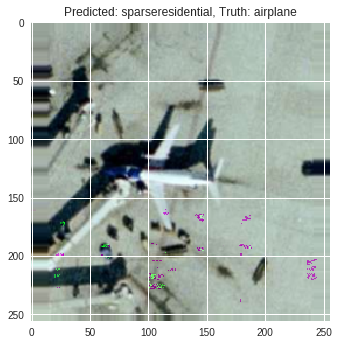

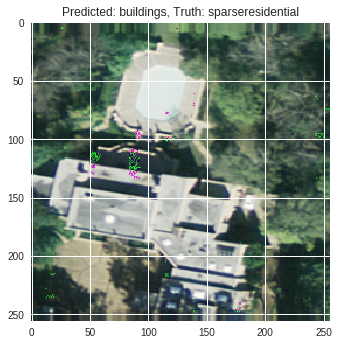

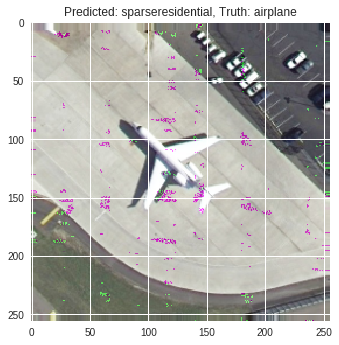

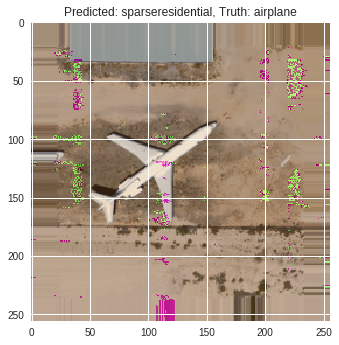

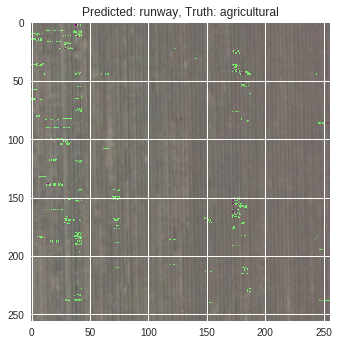

In [0]:
############# STILL WORKING ON THIS ############################################

#find the parts of images that activate the classification decision of the CNN
  # taken with modificaiton from:
    # https://github.com/jacobgil/keras-cam/blob/master/cam.py
import cv2
from keras.models import *
from keras.callbacks import *
import keras.backend as K

# tells you what each layer outputs
def get_output_layer(model, layer_name):
    # 'layer' is just the name of the layer in the summary above
  layer_dict = dict([(layer.name, layer) for layer in model.layers])
  layer = layer_dict[layer_name]
  return layer

# this shows you which parts of the image light up the activation map
def visualize_class_activation_map(original_img, truth):
  # read in the image and size it appropriately
  #original_img = cv2.imread(img_path, 1)

  width, height, _ = original_img.shape
  img = np.expand_dims(original_img[:, :, :], axis = 0)
  # gets the probabilities associated with each class in the output layer
  class_weights = model3.layers[-1].get_weights()[0]
  # gets the output from the final convolutional layer
  final_conv_layer = get_output_layer(model3, "conv2d_2")
  # define a function that maps an input image to the output of the final convolutional layer and the class predictions vector
                          # taking an input image     # and defining what the output should be
  get_output = K.function([model3.layers[0].input], [final_conv_layer.output, model3.layers[-1].output])
  # call the funciton on the input image
  [conv_outputs, predictions] = get_output([img])
  # outputs of the final convolutional layer
  conv_outputs = conv_outputs[0, :, :, :]

  #Create the class activation map.
  cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
  # this just builds the activation associated with each pixel in the image
  for i, w in enumerate(class_weights[0:251, 1]):
    cam += w * conv_outputs[i, :, :]
  predicted = model3.predict(img)
  y_class_pred = np.argmax(predicted)
  predicted_label = sorted(labels)[y_class_pred]
  # standardize the class activation map
  cam /= np.max(cam)
  cam = cv2.resize(cam, (height, width))
  # produce the heatmap to see which pixels are maximally activating
  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_AUTUMN)
  # turn down the level of the heatmap and overlay on the original image, then show the result
  heatmap[np.where(cam < 0.01)] = 0
  img = heatmap*.5 + original_img
  #prediction = labels[list(np.where(predictions == 1)[0])[0]]
  title_string = "Predicted: " + predicted_label + ", Truth: " + truth
  plt.title(title_string)
  plt.imshow(img)

# make a class activation heatmap for each of the classes
figsep = 1
for imag in images_to_use:
  #f = os.listdir('./TrainSet/'+l+'/')
  #image = './TrainSet/'+l+'/'+f[0]
  xs, ys = imag
  image = xs[0]
  plt.figure(figsep)
  y = [labels[np.argmax(l)] for l in ys][0]
  visualize_class_activation_map(image, y)
  figsep += 1


In [0]:
train_generator1 = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

images_to_use = []
images_that_break = []
found_ys = []
for imag in train_generator1:
  xs, ys = train_generator1.next()
  y = [labels[np.argmax(l)] for l in ys][0]
  predicted = model3.predict(np.expand_dims(xs[0][:, :, :], axis = 0))
  y_class_pred = np.argmax(predicted)
  predicted_label = sorted(labels)[y_class_pred] 
  if y == predicted_label and y not in found_ys:
    images_to_use.append(imag)
    found_ys.append(imag)
    print('Yay')
  else:
    images_that_break.append(image)
    


Found 1680 images belonging to 21 classes.
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay
Yay


KeyboardInterrupt: ignored

In [0]:
len(images_that_break)

52